# Baseline Improved Segmentor Analysis

This notebook provides a detailed analysis of each segmentation technique used in the baseline improved CAPTCHA detection pipeline. The baseline improved segmentor uses structural analysis techniques to handle merged and touching characters.

## Segmentation Pipeline Overview

The baseline improved segmentor employs the following segmentation strategies:

1. **Skeleton-Based Junction Detection**: Uses skeletonization to detect junction points where characters merge
2. **Histogram-Based Projection Analysis**: Analyzes vertical projection histograms to detect conglutinated characters
3. **Shape-Guided Segmentation**: Uses topological features (Euler number, endpoints, convex hull) to identify merged characters
4. **Connected Components Analysis**: Base method for finding character regions
5. **Line Removal and Cleaning**: Removes noise lines that interfere with segmentation

Each technique addresses specific challenges in CAPTCHA segmentation, particularly for touching and merged characters.


In [19]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from skimage.morphology import skeletonize, medial_axis
from skimage.measure import label, regionprops
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [20]:
# Load sample CAPTCHA images for analysis
data_dir = Path("../../data/main")
image_files = sorted(list(data_dir.glob("*.png")))[:1000]  # Load up to 1000 samples

sample_images = []
sample_labels = []

for img_path in image_files:
    img = cv2.imread(str(img_path))
    if img is not None:
        sample_images.append(img)
        sample_labels.append(img_path.stem)

print(f"Loaded {len(sample_images)} sample images")
print(f"Sample labels: {sample_labels[:5]}")


Loaded 151 sample images
Sample labels: ['0024miih-0', '002e23-0', '002k-0', '006aguv-0', '00fh-0']


In [26]:
# Import preprocessor for creating binary images
# (Simplified version for demonstration)
from skimage.filters import threshold_sauvola

class SimplePreprocessor:
    """Simplified preprocessor for creating binary images"""
    def _smart_grayscale(self, image):
        b, g, r = cv2.split(image)
        gray_standard = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        stds = [r.std(), g.std(), b.std(), gray_standard.std()]
        best_channel = [r, g, b, gray_standard][np.argmax(stds)]
        multi_channel_max = np.maximum(np.maximum(r, g), b)
        return np.maximum(best_channel, multi_channel_max)
    
    def _enhance_contrast(self, gray):
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(gray)
    
    def _adaptive_threshold(self, gray, block_size=15, C=2):
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, blockSize=block_size, C=C
        )
    
    def preprocess(self, image):
        gray = self._smart_grayscale(image)
        gray = self._enhance_contrast(gray)
        gray = cv2.equalizeHist(gray)
        _, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary_adaptive = self._adaptive_threshold(gray, block_size=15, C=2)
        thresh_sauvola = threshold_sauvola(gray, window_size=25, k=0.2)
        binary_sauvola = (gray < thresh_sauvola).astype(np.uint8) * 255
        binary = cv2.bitwise_or(binary_otsu, binary_adaptive)
        binary = cv2.bitwise_or(binary, binary_sauvola)
        return binary

preprocessor = SimplePreprocessor()
print("Preprocessor initialized!")


Preprocessor initialized!


In [35]:
# Import the EnhancedCAPTCHASegmenter class from baseline_improved notebook
# This segmenter uses skeleton, histogram, and shape-guided techniques

class EnhancedCAPTCHASegmenter:
    """Enhanced segmenter with structural analysis from baseline_improved"""
    
    def __init__(self, debug=False):
        self.debug = debug
        self.stats = {
            'skeleton_splits': 0,
            'histogram_splits': 0,
            'shape_guided_splits': 0,
            'standard_cca': 0,
            'total_processed': 0
        }
    
    def _clean_image(self, binary_image):
        """Remove background lines and noise while preserving character strokes"""
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        h_lines = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, h_kernel, iterations=1)
        cleaned = cv2.subtract(binary_image, h_lines)
        
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        v_lines = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, v_kernel, iterations=1)
        cleaned = cv2.subtract(cleaned, v_lines)
        
        noise_kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, noise_kernel, iterations=1)
        return cleaned
    
    def _find_components(self, binary_image, min_width=5, max_width=None, min_height=10):
        """Find initial connected components"""
        contours, _ = cv2.findContours(
            binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        
        char_boxes = []
        img_height, img_width = binary_image.shape
        
        if max_width is None:
            max_width = img_width // 3
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            
            min_area = max(35, img_height * img_width * 0.0022)
            max_area = img_height * img_width * 0.4
            
            if (w >= min_width and w <= max_width and 
                h >= min_height and h <= int(img_height * 0.95) and
                area >= min_area and area <= max_area):
                aspect_ratio = w / h if h > 0 else 0.0
                if 0.08 < aspect_ratio < 3.5:
                    region = binary_image[y:y+h, x:x+w]
                    on = np.sum(region > 0)
                    density = on / area if area > 0 else 0.0
                    
                    if area < 50:
                        min_density = 0.05
                    elif area < 200:
                        min_density = 0.035
                    else:
                        min_density = 0.03
                    
                    if density >= min_density:
                        char_boxes.append((x, y, x + w, y + h))
        
        return char_boxes
    
    def _detect_merged_chars_skeleton(self, region, min_cluster_sep=3):
        """
        Detect merged chars using clustered skeleton junction points.
        Returns (is_merged, split_columns)
        """
        # 0/1 skeleton
        binary_region = (region > 127).astype(bool)
        if binary_region.sum() < 10:  # tiny blob, skip
            return False, []

        skel = skeletonize(binary_region)

        h, w = skel.shape
        junction_xs = []

        for y in range(1, h - 1):
            for x in range(1, w - 1):
                if skel[y, x]:
                    neighbors = np.sum(skel[y-1:y+2, x-1:x+2]) - 1
                    if neighbors >= 3:
                        junction_xs.append(x)

        if len(junction_xs) < 3:
            return False, []

        # --- cluster junctions along x ---
        xs = np.array(sorted(junction_xs))
        clusters = []
        current = [xs[0]]

        for x in xs[1:]:
            if x - current[-1] <= min_cluster_sep:
                current.append(x)
            else:
                clusters.append(current)
                current = [x]
        clusters.append(current)

        # Ignore tiny clusters (likely noise)
        clusters = [c for c in clusters if len(c) >= 2]
        if len(clusters) <= 1:
            return False, []

        # Compute cluster centres
        centres = [int(np.mean(c)) for c in clusters]
        centres.sort()

        # Split positions are midpoints between adjacent cluster centres
        split_points = []
        for i in range(len(centres) - 1):
            split_x = (centres[i] + centres[i + 1]) // 2
            if 0 < split_x < w - 1:
                split_points.append(split_x)

        if not split_points:
            return False, []

        return True, split_points

    
    def _split_by_skeleton(self, binary_image, box):
        x1, y1, x2, y2 = box
        region = binary_image[y1:y2, x1:x2]

        is_merged, split_points = self._detect_merged_chars_skeleton(region)

        if not is_merged or not split_points:
            return [box]

        boxes = []
        boundaries = [0] + split_points + [region.shape[1]]

        for i in range(len(boundaries) - 1):
            x_start = boundaries[i]
            x_end = boundaries[i + 1]
            if x_end - x_start < 3:
                continue

            segment = region[:, x_start:x_end]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            if len(y_coords) == 0:
                continue

            boxes.append((
                x1 + x_start,
                y1 + y_coords[0],
                x1 + x_end,
                y1 + y_coords[-1] + 1
            ))

        if len(boxes) > 1:
            self.stats['skeleton_splits'] += 1
            return boxes

        return [box]

    
    def _analyze_projection_histogram(self, region, expected_avg_width):
        """Analyze vertical projection histogram to detect conglutinated characters"""
        proj = np.sum(region > 0, axis=0).astype(float)
        
        if len(proj) < 5:
            return False, 0.0, []
        
        proj_smooth = gaussian_filter1d(proj, sigma=1.5)
        proj_mean = np.mean(proj_smooth)
        proj_std = np.std(proj_smooth)
        
        width_ratio = region.shape[1] / expected_avg_width if expected_avg_width > 0 else 1.0
        
        threshold = proj_mean + proj_std * 0.3
        peaks = []
        for i in range(1, len(proj_smooth) - 1):
            if (proj_smooth[i] > threshold and 
                proj_smooth[i] > proj_smooth[i-1] and 
                proj_smooth[i] > proj_smooth[i+1]):
                peaks.append(i)
        
        valley_threshold = proj_mean * 0.25
        valleys = []
        for i in range(2, len(proj_smooth) - 2):
            if (proj_smooth[i] < valley_threshold and 
                proj_smooth[i] < proj_smooth[i-1] and 
                proj_smooth[i] < proj_smooth[i+1]):
                valleys.append(i)
        
        if len(valleys) > 1:
            filtered_valleys = [valleys[0]]
            min_dist = max(3, region.shape[1] // 5)
            for v in valleys[1:]:
                if v - filtered_valleys[-1] >= min_dist:
                    filtered_valleys.append(v)
            valleys = filtered_valleys
        
        is_conglutinated = False
        confidence = 0.0
        
        if len(peaks) >= 2 and width_ratio > 1.5:
            is_conglutinated = True
            confidence = min(1.0, 0.5 + (width_ratio - 1.5) * 0.3)
        elif width_ratio > 1.4 and len(valleys) >= 1:
            is_conglutinated = True
            confidence = min(1.0, 0.4 + len(valleys) * 0.2)
        elif width_ratio > 2.0:
            is_conglutinated = True
            confidence = 0.5
        
        return is_conglutinated, confidence, valleys
    
    def _split_by_histogram(self, binary_image, box, expected_avg_width):
        """Split component using histogram-based projection analysis"""
        x1, y1, x2, y2 = box
        region = binary_image[y1:y2, x1:x2]
        
        is_merged, confidence, valleys = self._analyze_projection_histogram(
            region, expected_avg_width
        )
        
        if not is_merged or not valleys:
            return [box]
        
        boxes = []
        boundaries = [0] + valleys + [region.shape[1]]
        
        for i in range(len(boundaries) - 1):
            x_start = boundaries[i]
            x_end = boundaries[i + 1]
            segment = region[:, x_start:x_end]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            
            if len(y_coords) > 0 and x_end - x_start >= 3:
                boxes.append((
                    x1 + x_start,
                    y1 + y_coords[0],
                    x1 + x_end,
                    y1 + y_coords[-1] + 1
                ))
        
        self.stats['histogram_splits'] += 1
        return boxes if len(boxes) > 1 else [box]
    
    def _extract_shape_features(self, region):
        """Extract topological and shape features from a region"""
        if region.shape[0] < 5 or region.shape[1] < 5:
            return None
        
        binary_region = (region > 127).astype(np.uint8)
        labeled = label(binary_region)
        props = regionprops(labeled)
        
        euler_number = 0
        if len(props) > 0:
            euler_number = props[0].euler_number
        
        skeleton = skeletonize(binary_region)
        endpoints = []
        skel_h, skel_w = skeleton.shape
        
        for y in range(1, skel_h - 1):
            for x in range(1, skel_w - 1):
                if skeleton[y, x]:
                    neighbors = np.sum(skeleton[y-1:y+2, x-1:x+2]) - 1
                    if neighbors == 1:
                        endpoints.append((x, y))
        
        contours, _ = cv2.findContours(binary_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_hull_ratio = 1.0
        if contours:
            cnt = contours[0]
            area = cv2.contourArea(cnt)
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            if hull_area > 0:
                convex_hull_ratio = area / hull_area
        
        complexity = len(endpoints) * 0.5 + abs(euler_number) * 2.0 + (1 - convex_hull_ratio) * 3.0
        
        return {
            'euler_number': euler_number,
            'endpoint_count': len(endpoints),
            'endpoints': endpoints,
            'convex_hull_ratio': convex_hull_ratio,
            'complexity': complexity
        }
    
    def _should_split_by_shape(self, features, width, expected_avg_width):
        """Decide if component should be split based on shape features"""
        if not features:
            return False, 0.0
        
        width_ratio = width / expected_avg_width if expected_avg_width > 0 else 1.0
        
        if width_ratio < 1.3:
            return False, 0.0
        
        confidence = 0.0
        should_split = False
        
        if features['euler_number'] < -1 and width_ratio > 1.5:
            should_split = True
            confidence = 0.8
        elif features['endpoint_count'] >= 6 and width_ratio > 1.4:
            should_split = True
            confidence = 0.7
        elif features['convex_hull_ratio'] < 0.7 and width_ratio > 1.5:
            should_split = True
            confidence = 0.6
        elif features['complexity'] > 8 and width_ratio > 1.4:
            should_split = True
            confidence = 0.5
        
        return should_split, confidence
    
    def _split_by_shape_guidance(self, binary_image, box, expected_avg_width):
        """Split component using shape-guided analysis"""
        x1, y1, x2, y2 = box
        region = binary_image[y1:y2, x1:x2]
        
        features = self._extract_shape_features(region)
        should_split, confidence = self._should_split_by_shape(
            features, region.shape[1], expected_avg_width
        )
        
        if not should_split:
            return [box]
        
        is_merged, hist_conf, valleys = self._analyze_projection_histogram(region, expected_avg_width)
        
        if is_merged and valleys:
            boxes = []
            boundaries = [0] + valleys + [region.shape[1]]
            
            for i in range(len(boundaries) - 1):
                x_start = boundaries[i]
                x_end = boundaries[i + 1]
                segment = region[:, x_start:x_end]
                y_coords = np.where(np.any(segment > 0, axis=1))[0]
                
                if len(y_coords) > 0 and x_end - x_start >= 3:
                    boxes.append((
                        x1 + x_start,
                        y1 + y_coords[0],
                        x1 + x_end,
                        y1 + y_coords[-1] + 1
                    ))
            
            if len(boxes) > 1:
                self.stats['shape_guided_splits'] += 1
                return boxes
        
        return [box]
    
    def _intelligent_split_pipeline(self, binary_image, components, expected_chars, 
                                    min_char_width, max_char_width):
        """Intelligent splitting pipeline using multiple techniques"""
        if len(components) == 0:
            return []
        
        avg_width = np.median([c[2] - c[0] for c in components]) if components else 50
        
        result_boxes = []
        
        for box in components:
            box_width = box[2] - box[0]
            
            if box_width <= avg_width * 1.3:
                result_boxes.append(box)
                self.stats['standard_cca'] += 1
                continue
            
            skeleton_boxes = self._split_by_skeleton(binary_image, box)
            if len(skeleton_boxes) > 1:
                result_boxes.extend(skeleton_boxes)
                continue
            
            histogram_boxes = self._split_by_histogram(binary_image, box, avg_width)
            if len(histogram_boxes) > 1:
                result_boxes.extend(histogram_boxes)
                continue
            
            shape_boxes = self._split_by_shape_guidance(binary_image, box, avg_width)
            if len(shape_boxes) > 1:
                result_boxes.extend(shape_boxes)
                continue
            
            result_boxes.append(box)
            self.stats['standard_cca'] += 1
        
        return result_boxes
    
    def _post_process_boxes(self, binary_image, boxes, expected_chars):
        """Post-process: merge close boxes and filter if needed"""
        if len(boxes) <= 1:
            return boxes
        
        sorted_boxes = sorted(boxes, key=lambda x: x[0])
        merged = []
        
        for i, current in enumerate(sorted_boxes):
            if i + 1 < len(sorted_boxes):
                next_box = sorted_boxes[i + 1]
                gap = next_box[0] - current[2]
                
                if gap < 5:
                    merged_box = (
                        current[0],
                        min(current[1], next_box[1]),
                        next_box[2],
                        max(current[3], next_box[3])
                    )
                    merged.append(merged_box)
                    i += 2
                    continue
            
            merged.append(current)
            i += 1
        
        if expected_chars and len(merged) > expected_chars:
            merged = self._filter_oversegmented(binary_image, merged, expected_chars)
        
        return merged
    
    def _filter_oversegmented(self, binary_image, boxes, expected_chars):
        """Intelligently filter down to expected number of characters"""
        img_h, img_w = binary_image.shape
        box_scores = []
        
        areas = [(b[2] - b[0]) * (b[3] - b[1]) for b in boxes]
        median_area = np.median(areas)
        
        for box in boxes:
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            area = w * h
            region = binary_image[y1:y2, x1:x2]
            density = np.sum(region > 0) / area if area > 0 else 0
            
            score = area
            
            if area < median_area * 0.3:
                score *= 0.2
            if density < 0.05:
                score *= 0.3
            
            aspect = w / h if h > 0 else 0
            if aspect < 0.15 or aspect > 3.0:
                score *= 0.5
            if h < img_h * 0.15:
                score *= 0.4
            
            box_scores.append((box, score))
        
        box_scores.sort(key=lambda x: x[1], reverse=True)
        filtered = [box for box, _ in box_scores[:expected_chars]]
        return sorted(filtered, key=lambda x: x[0])
    
    def segment(self, binary_image, expected_chars=None, 
                min_char_width=5, max_char_width=None, min_char_height=10):
        """Main segmentation pipeline"""
        self.stats['total_processed'] += 1
        
        if binary_image.max() <= 1:
            binary_image = (binary_image * 255).astype(np.uint8)
        
        cleaned = self._clean_image(binary_image)
        components = self._find_components(cleaned, min_char_width, max_char_width, min_char_height)
        
        if expected_chars:
            char_boxes = self._intelligent_split_pipeline(
                cleaned, components, expected_chars, min_char_width, max_char_width
            )
        else:
            char_boxes = components
        
        char_boxes = self._post_process_boxes(cleaned, char_boxes, expected_chars)
        char_boxes = sorted(char_boxes, key=lambda x: x[0])
        
        return char_boxes
    
    def visualize_segmentation(self, original_image, binary_image, char_boxes, title="Segmentation"):
        """Visualize segmentation results"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        if len(original_image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(original_image, cmap="gray")
        axes[0].set_title("Original")
        axes[0].axis("off")
        
        axes[1].imshow(binary_image, cmap="gray")
        axes[1].set_title("Preprocessed")
        axes[1].axis("off")
        
        axes[2].imshow(binary_image, cmap="gray")
        axes[2].set_title(f"{title} ({len(char_boxes)} chars)")
        for x1, y1, x2, y2 in char_boxes:
            rect = Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            axes[2].add_patch(rect)
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()

# Initialize segmenter
segmenter = EnhancedCAPTCHASegmenter()
print("Segmenter initialized!")


Segmenter initialized!


TECHNIQUE 1: SKELETON-BASED JUNCTION DETECTION

Searching for samples with wide components...
Found 3 suitable samples. Showing examples:

Example 1: 00wi5-0 (sample #8)


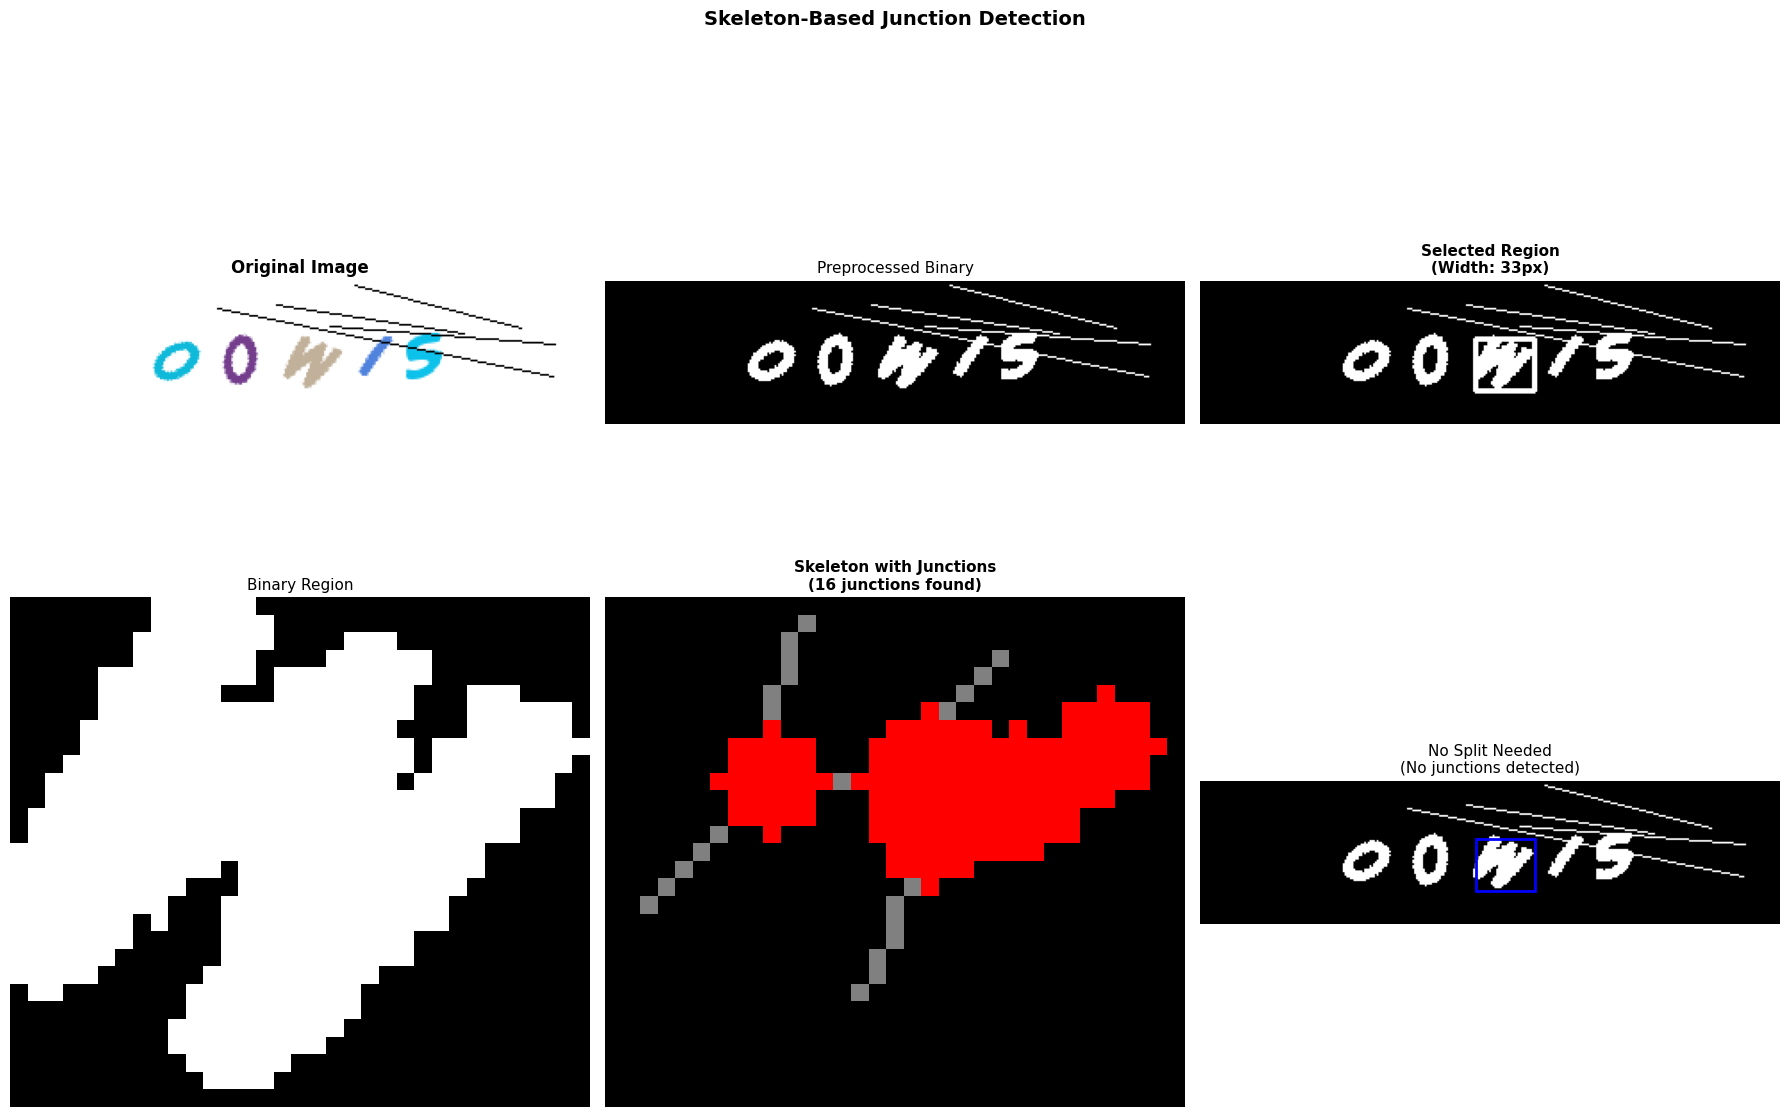

Region width: 33px
Junctions detected: 16
Is merged: False


Example 2: 02cc-0 (sample #17)


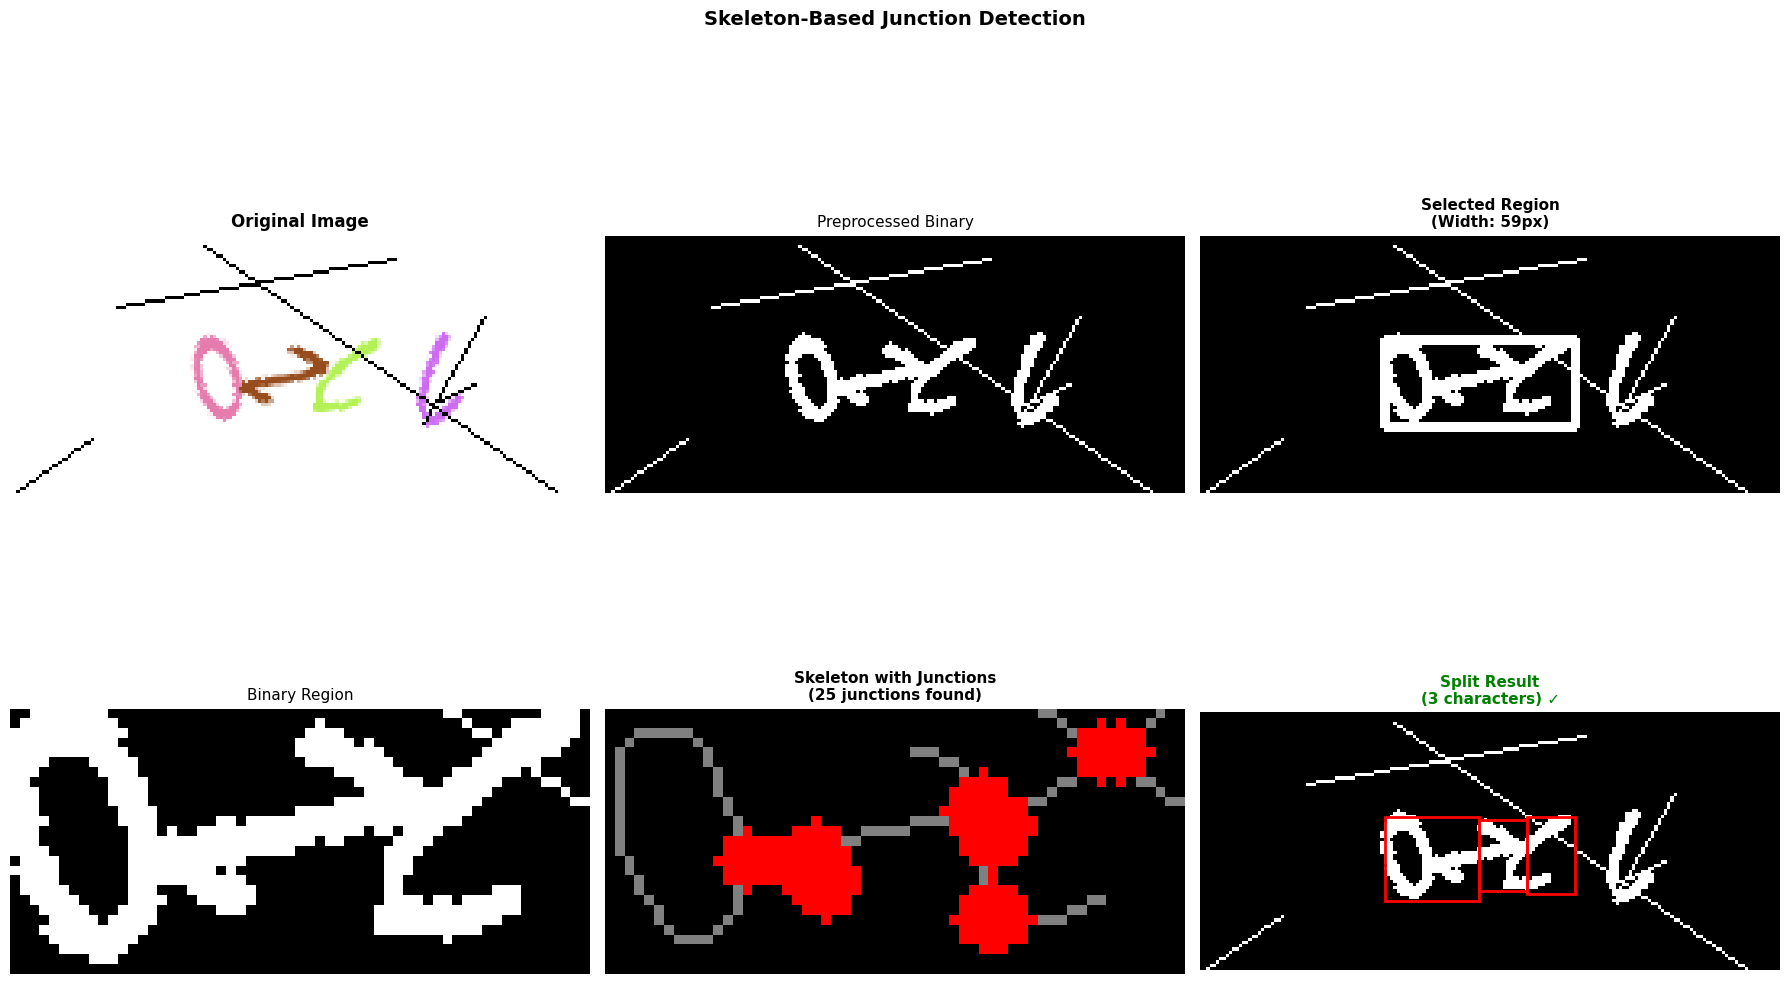

Region width: 59px
Junctions detected: 25
Is merged: True
Split points: [29, 44]
Result: Split into 3 characters


Example 3: 03mxgd-0 (sample #21)


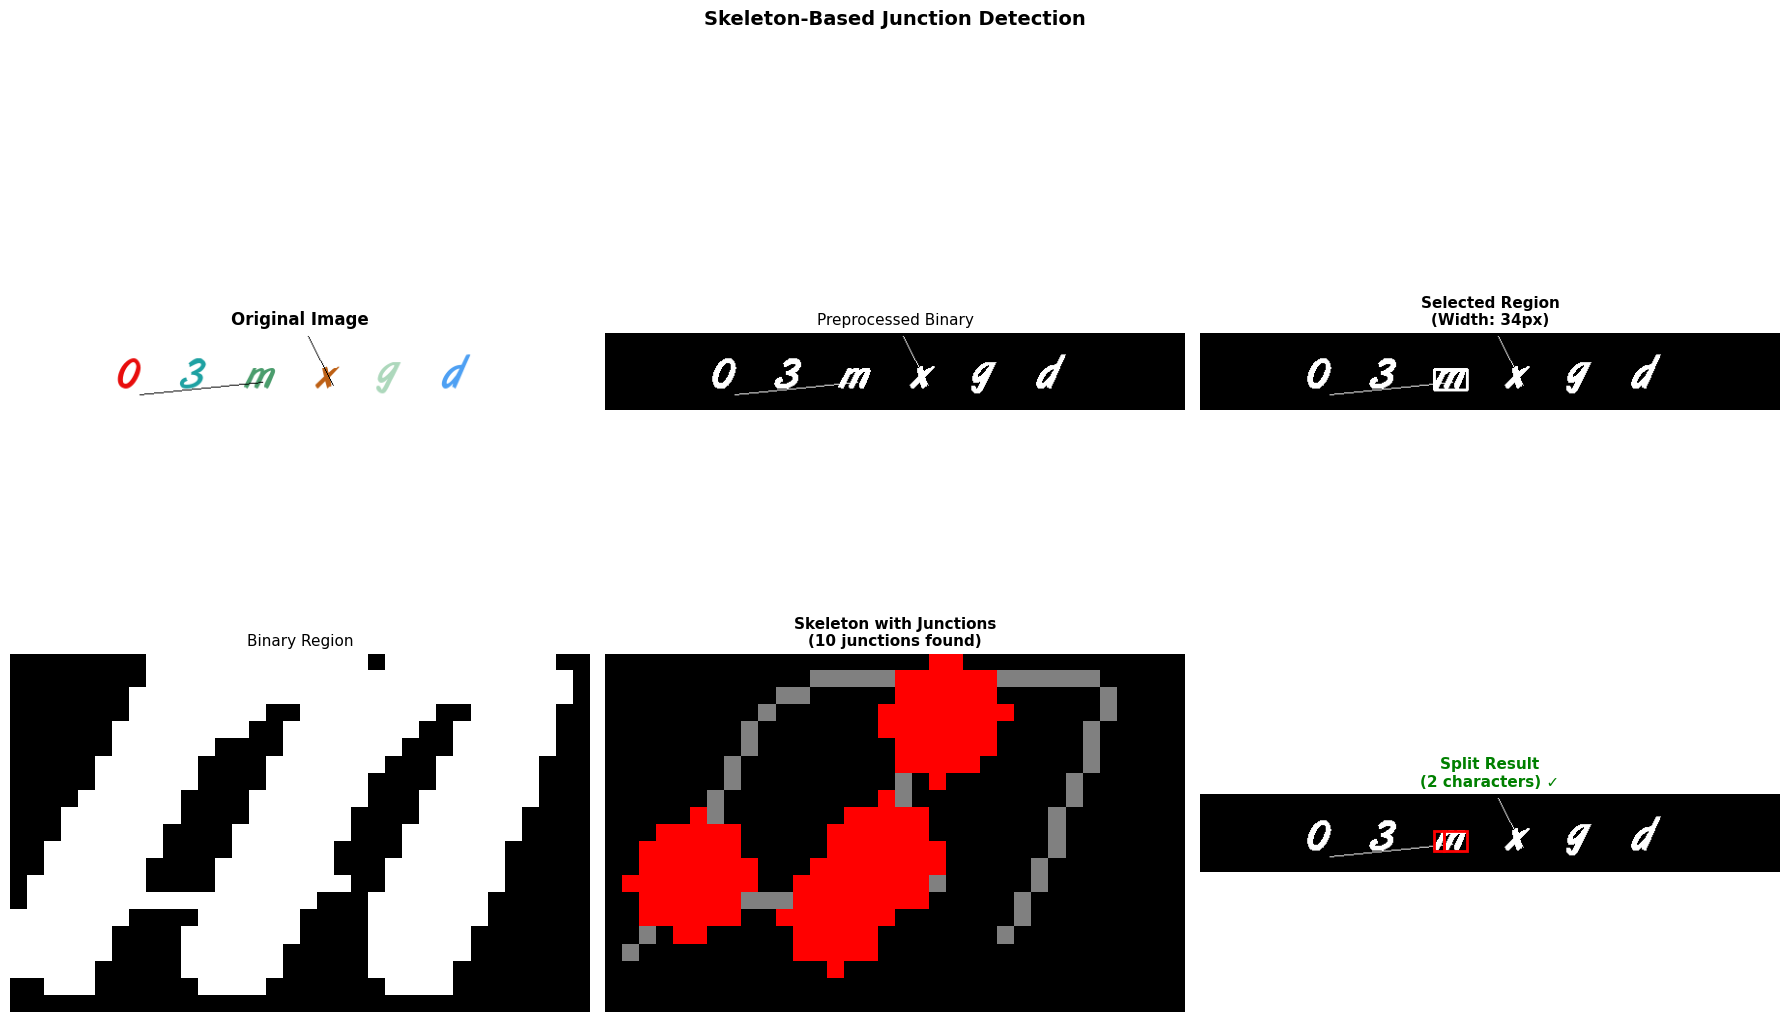

Region width: 34px
Junctions detected: 10
Is merged: True
Split points: [10]
Result: Split into 2 characters




In [36]:
# Helper function to find samples with wide components
def find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, 
                                      min_width=40, max_samples=1000):
    """Find samples that have wide components suitable for demonstration"""
    good_samples = []
    
    for idx, (img, label) in enumerate(zip(sample_images[:max_samples], sample_labels[:max_samples])):
        try:
            binary = preprocessor.preprocess(img)
            cleaned = segmenter._clean_image(binary)
            components = segmenter._find_components(cleaned, min_width=5, min_height=10)
            
            # Find wide components
            wide_components = [c for c in components if (c[2] - c[0]) > min_width]
            
            if len(wide_components) > 0:
                good_samples.append((idx, img, label, wide_components[0]))
                
                if len(good_samples) >= 3:  # Found enough examples
                    break
        except Exception as e:
            continue
    
    return good_samples

# Visualize Skeleton-Based Junction Detection
def visualize_skeleton_detection(image, preprocessor, segmenter):
    """Compare original region vs skeleton with junction detection"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    
    # Find components
    cleaned = segmenter._clean_image(binary)
    components = segmenter._find_components(cleaned, min_width=5, min_height=10)
    
    # Find a wide component that might be merged (for demonstration)
    # Try different width thresholds
    wide_components = []
    for threshold in [40, 35, 30, 25]:
        wide_components = [c for c in components if (c[2] - c[0]) > threshold]
        if len(wide_components) > 0:
            break
    
    if len(wide_components) == 0:
        print("No wide components found for skeleton analysis demonstration")
        return None
    
    # Use first wide component
    box = wide_components[0]
    x1, y1, x2, y2 = box
    region = binary[y1:y2, x1:x2]
    
    # Create binary region
    binary_region = (region > 127).astype(np.uint8)
    
    # Skeletonize
    skeleton = skeletonize(binary_region)
    
    # Detect junctions
    junctions = []
    skel_h, skel_w = skeleton.shape
    
    for y in range(1, skel_h - 1):
        for x in range(1, skel_w - 1):
            if skeleton[y, x]:
                neighbors = np.sum(skeleton[y-1:y+2, x-1:x+2]) - 1
                if neighbors >= 3:
                    junctions.append((x, y))
    
    # Detect if merged and get split points
    is_merged, split_points = segmenter._detect_merged_chars_skeleton(region)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and binary region
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(binary, cmap='gray')
    axes[0, 1].set_title('Preprocessed Binary', fontsize=11)
    axes[0, 1].axis('off')
    
    # Show the selected region
    region_display = binary.copy()
    cv2.rectangle(region_display, (x1, y1), (x2, y2), 255, 2)
    axes[0, 2].imshow(region_display, cmap='gray')
    axes[0, 2].set_title(f'Selected Region\n(Width: {x2-x1}px)', fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Skeleton analysis
    axes[1, 0].imshow(binary_region, cmap='gray')
    axes[1, 0].set_title('Binary Region', fontsize=11)
    axes[1, 0].axis('off')
    
    # Show skeleton with junctions
    skeleton_display = np.zeros_like(binary_region)
    skeleton_display[skeleton > 0] = 128
    skeleton_display = cv2.cvtColor(skeleton_display, cv2.COLOR_GRAY2RGB)
    
    # Mark junctions in red
    for jx, jy in junctions:
        cv2.circle(skeleton_display, (jx, jy), 3, (255, 0, 0), -1)
    
    axes[1, 1].imshow(skeleton_display)
    axes[1, 1].set_title(f'Skeleton with Junctions\n({len(junctions)} junctions found)', 
                         fontsize=11, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Show split result
    if is_merged and split_points:
        split_boxes = segmenter._split_by_skeleton(binary, box)
        axes[1, 2].imshow(binary, cmap='gray')
        axes[1, 2].set_title(f'Split Result\n({len(split_boxes)} characters) ✓', 
                             fontsize=11, fontweight='bold', color='green')
        
        for sx1, sy1, sx2, sy2 in split_boxes:
            rect = Rectangle((sx1, sy1), sx2-sx1, sy2-sy1, 
                            linewidth=2, edgecolor='red', facecolor='none')
            axes[1, 2].add_patch(rect)
    else:
        axes[1, 2].imshow(binary, cmap='gray')
        axes[1, 2].set_title('No Split Needed\n(No junctions detected)', 
                             fontsize=11)
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='blue', facecolor='none')
        axes[1, 2].add_patch(rect)
    axes[1, 2].axis('off')
    
    plt.suptitle('Skeleton-Based Junction Detection', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Region width: {x2-x1}px")
    print(f"Junctions detected: {len(junctions)}")
    print(f"Is merged: {is_merged}")
    if is_merged:
        print(f"Split points: {split_points}")
        print(f"Result: Split into {len(split_boxes)} characters")
    print()
    
    return {'is_merged': is_merged, 'junctions': len(junctions), 'split_boxes': len(split_boxes) if is_merged else 1}

# Test on multiple samples - find good examples first
print("="*70)
print("TECHNIQUE 1: SKELETON-BASED JUNCTION DETECTION")
print("="*70)
print()
print("Searching for samples with wide components...")

good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=30)

if len(good_samples) == 0:
    print("No suitable samples found. Trying with lower threshold...")
    good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=25)

if len(good_samples) > 0:
    print(f"Found {len(good_samples)} suitable samples. Showing examples:\n")
    for i, (idx, img, label, _) in enumerate(good_samples[:3]):
        print(f"Example {i+1}: {label} (sample #{idx})")
        result = visualize_skeleton_detection(img, preprocessor, segmenter)
        if result is None:
            print(f"  → No skeleton split detected for this sample\n")
        else:
            print()
else:
    print("No suitable samples found even with relaxed criteria.")
    print("Showing first 3 samples anyway for reference:\n")
    for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
        print(f"Example {i+1}: {label}")
        visualize_skeleton_detection(img, preprocessor, segmenter)


TECHNIQUE 2: HISTOGRAM-BASED PROJECTION ANALYSIS

Searching for samples with wide components...
Found 3 suitable samples. Showing examples:

Example 1: 00wi5-0 (sample #8)


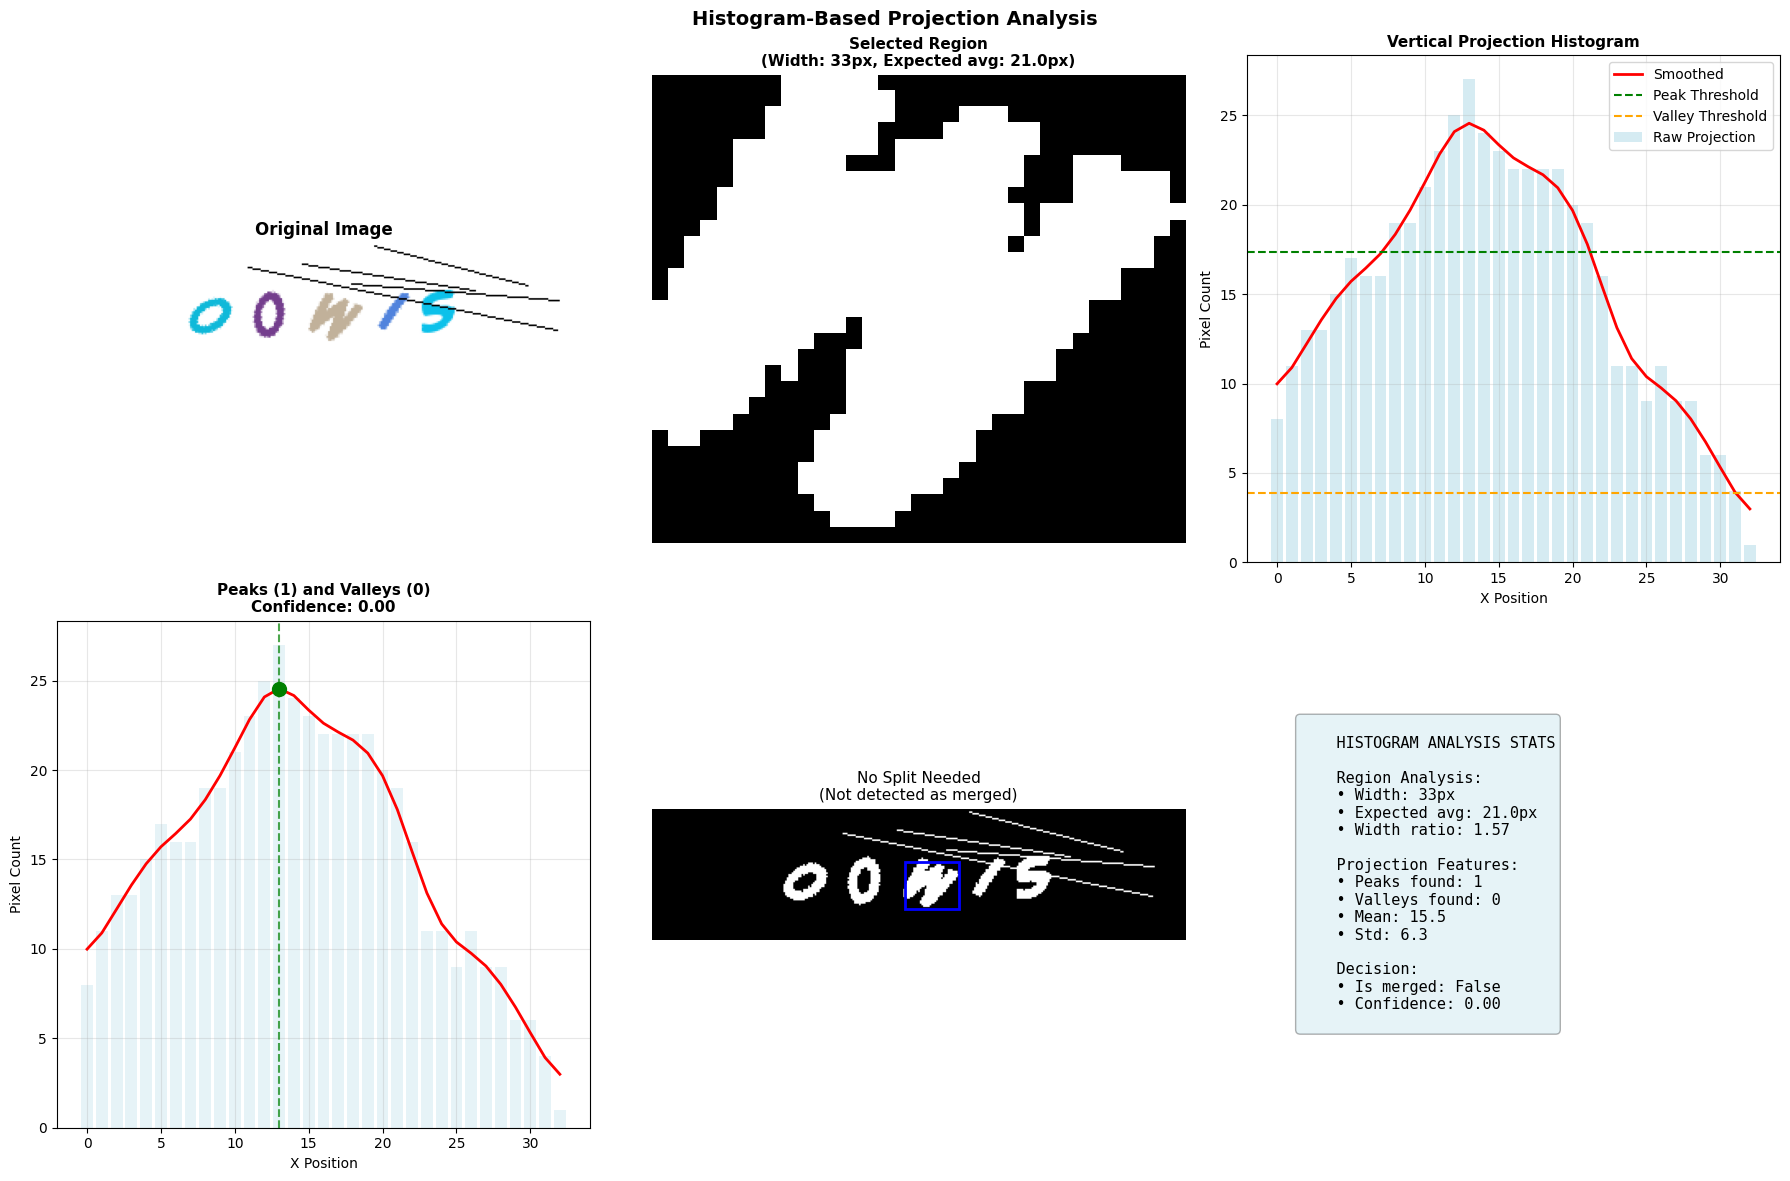

Width ratio: 1.57
Peaks: 1, Valleys: 0
Is merged: False, Confidence: 0.00


Example 2: 02cc-0 (sample #17)


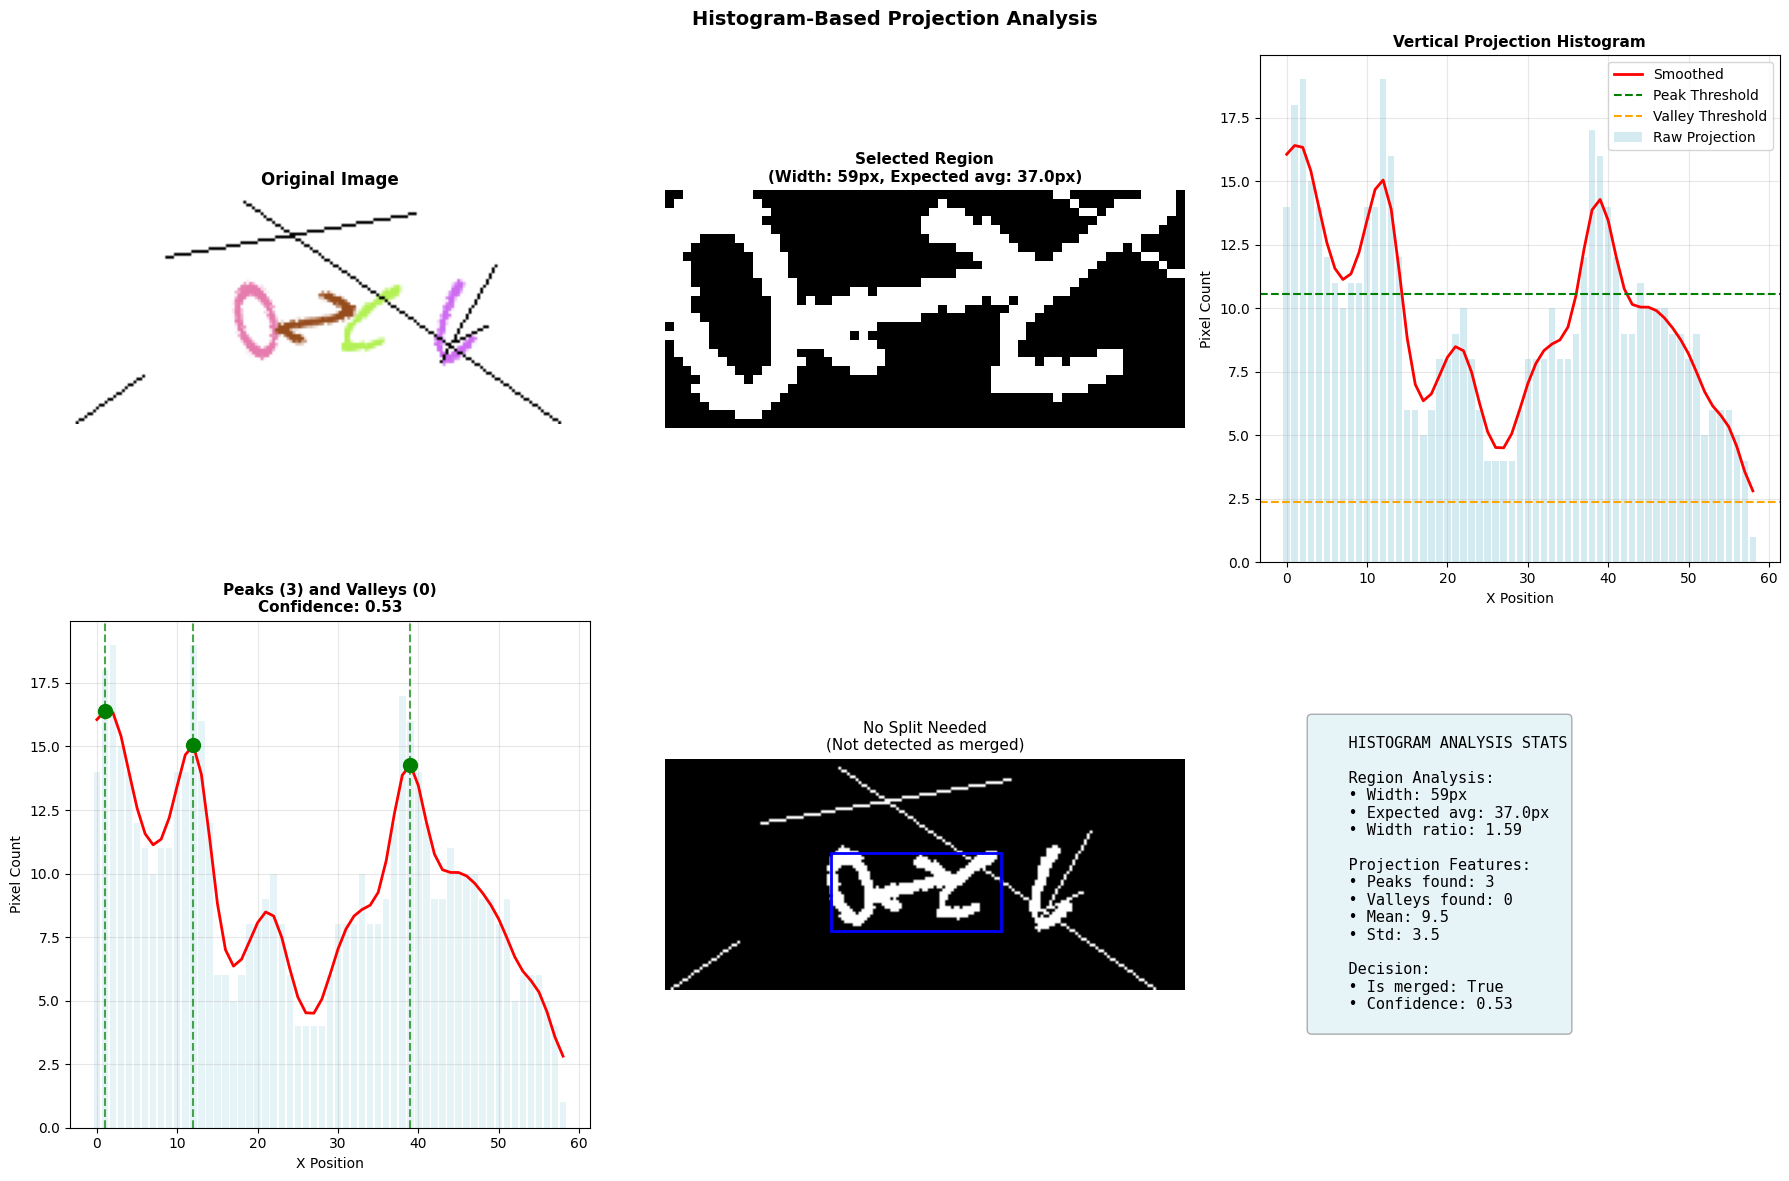

Width ratio: 1.59
Peaks: 3, Valleys: 0
Is merged: True, Confidence: 0.53


Example 3: 03mxgd-0 (sample #21)


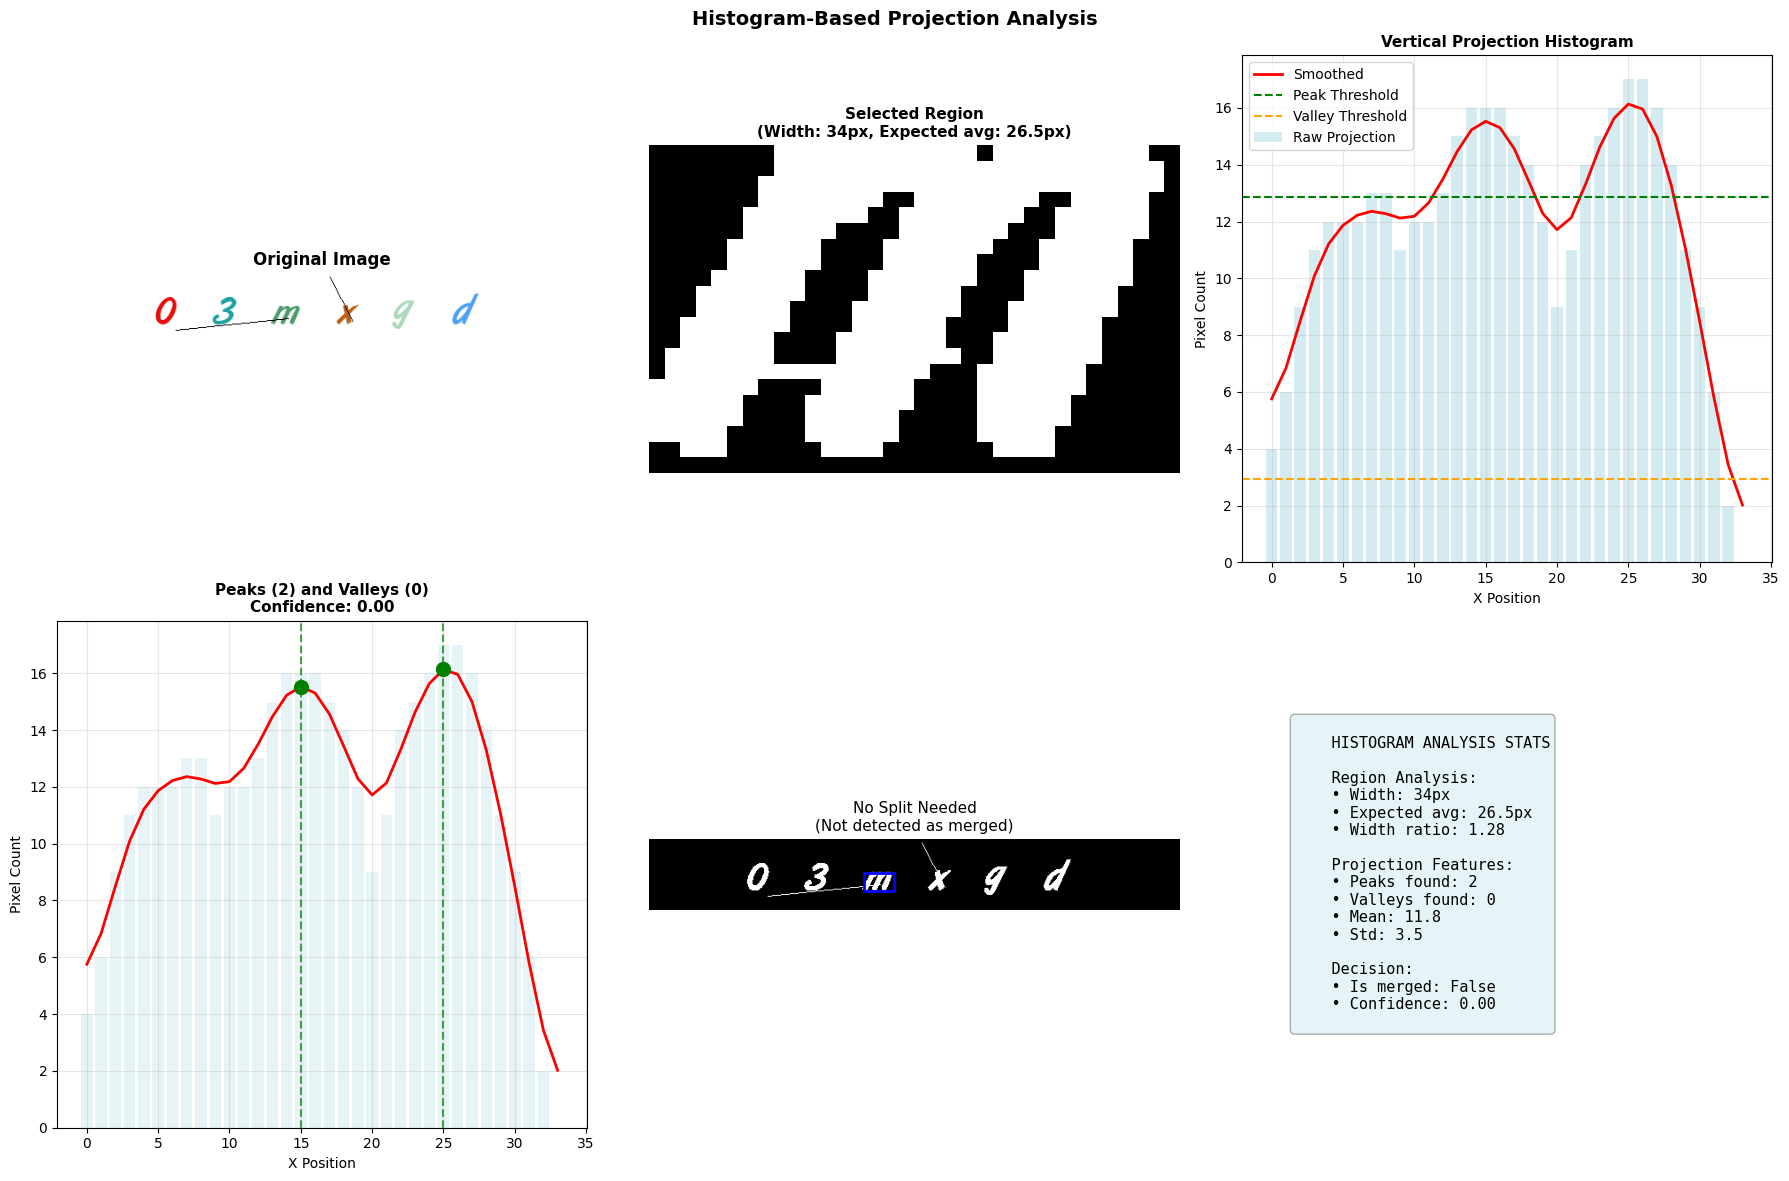

Width ratio: 1.28
Peaks: 2, Valleys: 0
Is merged: False, Confidence: 0.00




In [29]:
# Visualize Histogram-Based Projection Analysis
def visualize_histogram_analysis(image, preprocessor, segmenter):
    """Compare regions with and without histogram-based splitting"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    
    # Find components
    cleaned = segmenter._clean_image(binary)
    components = segmenter._find_components(cleaned, min_width=5, min_height=10)
    
    # Find a wide component - try different thresholds
    wide_components = []
    for threshold in [40, 35, 30, 25]:
        wide_components = [c for c in components if (c[2] - c[0]) > threshold]
        if len(wide_components) > 0:
            break
    
    if len(wide_components) == 0:
        print("No wide components found for histogram analysis demonstration")
        return None
    
    box = wide_components[0]
    x1, y1, x2, y2 = box
    region = binary[y1:y2, x1:x2]
    
    # Calculate average width for comparison
    avg_width = np.median([c[2] - c[0] for c in components]) if components else 30
    
    # Analyze projection histogram
    proj = np.sum(region > 0, axis=0).astype(float)
    proj_smooth = gaussian_filter1d(proj, sigma=1.5)
    
    proj_mean = np.mean(proj_smooth)
    proj_std = np.std(proj_smooth)
    
    # Find peaks
    threshold = proj_mean + proj_std * 0.3
    peaks = []
    for i in range(1, len(proj_smooth) - 1):
        if (proj_smooth[i] > threshold and 
            proj_smooth[i] > proj_smooth[i-1] and 
            proj_smooth[i] > proj_smooth[i+1]):
            peaks.append(i)
    
    # Find valleys
    valley_threshold = proj_mean * 0.25
    valleys = []
    for i in range(2, len(proj_smooth) - 2):
        if (proj_smooth[i] < valley_threshold and 
            proj_smooth[i] < proj_smooth[i-1] and 
            proj_smooth[i] < proj_smooth[i+1]):
            valleys.append(i)
    
    # Filter valleys
    if len(valleys) > 1:
        filtered_valleys = [valleys[0]]
        min_dist = max(3, region.shape[1] // 5)
        for v in valleys[1:]:
            if v - filtered_valleys[-1] >= min_dist:
                filtered_valleys.append(v)
        valleys = filtered_valleys
    
    # Check if merged
    is_merged, confidence, split_valleys = segmenter._analyze_projection_histogram(region, avg_width)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and region
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(region, cmap='gray')
    axes[0, 1].set_title(f'Selected Region\n(Width: {region.shape[1]}px, Expected avg: {avg_width:.1f}px)', 
                         fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Show projection
    axes[0, 2].bar(range(len(proj)), proj, alpha=0.5, color='lightblue', label='Raw Projection')
    axes[0, 2].plot(proj_smooth, 'r-', linewidth=2, label='Smoothed')
    axes[0, 2].axhline(threshold, color='green', linestyle='--', label='Peak Threshold')
    axes[0, 2].axhline(valley_threshold, color='orange', linestyle='--', label='Valley Threshold')
    axes[0, 2].set_xlabel('X Position')
    axes[0, 2].set_ylabel('Pixel Count')
    axes[0, 2].set_title('Vertical Projection Histogram', fontsize=11, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Row 2: Analysis results
    # Show peaks and valleys
    axes[1, 0].bar(range(len(proj)), proj, alpha=0.3, color='lightblue')
    axes[1, 0].plot(proj_smooth, 'r-', linewidth=2)
    for peak in peaks:
        axes[1, 0].axvline(peak, color='green', linestyle='--', alpha=0.7)
        axes[1, 0].plot(peak, proj_smooth[peak], 'go', markersize=10)
    for valley in split_valleys:
        axes[1, 0].axvline(valley, color='red', linestyle='--', linewidth=2, alpha=0.7)
        axes[1, 0].plot(valley, proj_smooth[valley], 'ro', markersize=10)
    axes[1, 0].set_xlabel('X Position')
    axes[1, 0].set_ylabel('Pixel Count')
    axes[1, 0].set_title(f'Peaks ({len(peaks)}) and Valleys ({len(split_valleys)})\nConfidence: {confidence:.2f}', 
                         fontsize=11, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Show split result
    if is_merged and split_valleys:
        split_boxes = segmenter._split_by_histogram(binary, box, avg_width)
        axes[1, 1].imshow(binary, cmap='gray')
        axes[1, 1].set_title(f'Histogram Split Result\n({len(split_boxes)} characters) ✓', 
                            fontsize=11, fontweight='bold', color='green')
        
        for sx1, sy1, sx2, sy2 in split_boxes:
            rect = Rectangle((sx1, sy1), sx2-sx1, sy2-sy1, 
                            linewidth=2, edgecolor='red', facecolor='none')
            axes[1, 1].add_patch(rect)
    else:
        axes[1, 1].imshow(binary, cmap='gray')
        axes[1, 1].set_title('No Split Needed\n(Not detected as merged)', 
                             fontsize=11)
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='blue', facecolor='none')
        axes[1, 1].add_patch(rect)
    axes[1, 1].axis('off')
    
    # Show statistics
    width_ratio = region.shape[1] / avg_width if avg_width > 0 else 1.0
    axes[1, 2].axis('off')
    stats_text = f"""
    HISTOGRAM ANALYSIS STATS
    
    Region Analysis:
    • Width: {region.shape[1]}px
    • Expected avg: {avg_width:.1f}px
    • Width ratio: {width_ratio:.2f}
    
    Projection Features:
    • Peaks found: {len(peaks)}
    • Valleys found: {len(split_valleys)}
    • Mean: {proj_mean:.1f}
    • Std: {proj_std:.1f}
    
    Decision:
    • Is merged: {is_merged}
    • Confidence: {confidence:.2f}
    """
    axes[1, 2].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle('Histogram-Based Projection Analysis', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"Width ratio: {width_ratio:.2f}")
    print(f"Peaks: {len(peaks)}, Valleys: {len(split_valleys)}")
    print(f"Is merged: {is_merged}, Confidence: {confidence:.2f}")
    print()
    
    return {'is_merged': is_merged, 'confidence': confidence, 'peaks': len(peaks), 'valleys': len(split_valleys)}

# Test on multiple samples - find good examples first
print("="*70)
print("TECHNIQUE 2: HISTOGRAM-BASED PROJECTION ANALYSIS")
print("="*70)
print()
print("Searching for samples with wide components...")

good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=30)

if len(good_samples) == 0:
    print("No suitable samples found. Trying with lower threshold...")
    good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=25)

if len(good_samples) > 0:
    print(f"Found {len(good_samples)} suitable samples. Showing examples:\n")
    for i, (idx, img, label, _) in enumerate(good_samples[:3]):
        print(f"Example {i+1}: {label} (sample #{idx})")
        result = visualize_histogram_analysis(img, preprocessor, segmenter)
        if result is None:
            print(f"  → No histogram split detected for this sample\n")
        else:
            print()
else:
    print("No suitable samples found even with relaxed criteria.")
    print("Showing first 3 samples anyway for reference:\n")
    for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
        print(f"Example {i+1}: {label}")
        visualize_histogram_analysis(img, preprocessor, segmenter)


## Technique 3: Shape-Guided Segmentation

**Problem**: Some merged characters may not be detected by skeleton or histogram methods alone. Topological and shape features can provide additional signals for identifying merged characters.

**Solution**: Extract and analyze shape features:
- **Euler Number**: Counts loops/holes (e.g., 'o', '8', 'b' have loops)
- **Endpoint Count**: Number of stroke terminals (multiple characters = more endpoints)
- **Convex Hull Ratio**: How much the shape deviates from its convex hull
- **Complexity Score**: Combined metric of shape complexity
- Use these features to decide if splitting is needed, then apply histogram-based splitting

**Improvement**: Provides a complementary approach that catches merged characters missed by other methods, especially those with distinctive topological features.


In [37]:
# Visualize Shape-Guided Segmentation
def visualize_shape_analysis(image, preprocessor, segmenter):
    """Compare shape features for merged character detection"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    
    # Find components
    cleaned = segmenter._clean_image(binary)
    components = segmenter._find_components(cleaned, min_width=5, min_height=10)
    
    # Find a wide component - try different thresholds
    wide_components = []
    for threshold in [40, 35, 30, 25]:
        wide_components = [c for c in components if (c[2] - c[0]) > threshold]
        if len(wide_components) > 0:
            break
    
    if len(wide_components) == 0:
        print("No wide components found for shape analysis demonstration")
        return None
    
    box = wide_components[0]
    x1, y1, x2, y2 = box
    region = binary[y1:y2, x1:x2]
    
    # Calculate average width
    avg_width = np.median([c[2] - c[0] for c in components]) if components else 30
    
    # Extract shape features
    features = segmenter._extract_shape_features(region)
    
    # Check if should split
    should_split, confidence = segmenter._should_split_by_shape(
        features, region.shape[1], avg_width
    )
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and region
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(region, cmap='gray')
    axes[0, 1].set_title(f'Selected Region\n(Width: {region.shape[1]}px)', 
                         fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Show skeleton with endpoints
    binary_region = (region > 127).astype(np.uint8)
    skeleton = skeletonize(binary_region)
    skeleton_display = np.zeros_like(binary_region)
    skeleton_display[skeleton > 0] = 128
    skeleton_display = cv2.cvtColor(skeleton_display, cv2.COLOR_GRAY2RGB)
    
    if features:
        for ex, ey in features['endpoints']:
            cv2.circle(skeleton_display, (ex, ey), 3, (0, 255, 0), -1)
    
    axes[0, 2].imshow(skeleton_display)
    axes[0, 2].set_title(f'Skeleton with Endpoints\n({features["endpoint_count"] if features else 0} endpoints)', 
                         fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Shape features and result
    # Show convex hull
    contours, _ = cv2.findContours(binary_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull_display = cv2.cvtColor(binary_region, cv2.COLOR_GRAY2RGB)
    if contours:
        hull = cv2.convexHull(contours[0])
        cv2.drawContours(hull_display, [hull], -1, (0, 255, 0), 2)
        cv2.drawContours(hull_display, contours, -1, (255, 0, 0), 1)
    
    axes[1, 0].imshow(hull_display)
    axes[1, 0].set_title(f'Convex Hull\n(Ratio: {features["convex_hull_ratio"]:.2f if features else 1.0})', 
                         fontsize=11)
    axes[1, 0].axis('off')
    
    # Show split result
    if should_split:
        split_boxes = segmenter._split_by_shape_guidance(binary, box, avg_width)
        axes[1, 1].imshow(binary, cmap='gray')
        axes[1, 1].set_title(f'Shape-Guided Split Result\n({len(split_boxes)} characters) ✓', 
                            fontsize=11, fontweight='bold', color='green')
        
        for sx1, sy1, sx2, sy2 in split_boxes:
            rect = Rectangle((sx1, sy1), sx2-sx1, sy2-sy1, 
                            linewidth=2, edgecolor='red', facecolor='none')
            axes[1, 1].add_patch(rect)
    else:
        axes[1, 1].imshow(binary, cmap='gray')
        axes[1, 1].set_title('No Split Needed\n(Shape features do not indicate merge)', 
                             fontsize=11)
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='blue', facecolor='none')
        axes[1, 1].add_patch(rect)
    axes[1, 1].axis('off')
    
    # Show statistics
    axes[1, 2].axis('off')
    if features:
        stats_text = f"""
        SHAPE FEATURE ANALYSIS
        
        Topological Features:
        • Euler number: {features['euler_number']}
          (negative = loops/holes)
        • Endpoints: {features['endpoint_count']}
          (stroke terminals)
        
        Geometric Features:
        • Convex hull ratio: {features['convex_hull_ratio']:.2f}
          (lower = more complex)
        • Complexity score: {features['complexity']:.2f}
        
        Decision:
        • Should split: {should_split}
        • Confidence: {confidence:.2f}
        """
    else:
        stats_text = "No shape features extracted\n(Region too small)"
    axes[1, 2].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle('Shape-Guided Segmentation', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    if features:
        print(f"Euler number: {features['euler_number']}")
        print(f"Endpoints: {features['endpoint_count']}")
        print(f"Convex hull ratio: {features['convex_hull_ratio']:.2f}")
        print(f"Complexity: {features['complexity']:.2f}")
        print(f"Should split: {should_split}, Confidence: {confidence:.2f}")
    print()
    
    return {'should_split': should_split, 'confidence': confidence, 'features': features}

# Test on multiple samples - find good examples first
print("="*70)
print("TECHNIQUE 3: SHAPE-GUIDED SEGMENTATION")
print("="*70)
print()
print("Searching for samples with wide components...")

good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=30)

if len(good_samples) == 0:
    print("No suitable samples found. Trying with lower threshold...")
    good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=25)

if len(good_samples) > 0:
    print(f"Found {len(good_samples)} suitable samples. Showing examples:\n")
    for i, (idx, img, label, _) in enumerate(good_samples[:3]):
        print(f"Example {i+1}: {label} (sample #{idx})")
        result = visualize_shape_analysis(img, preprocessor, segmenter)
        if result is None:
            print(f"  → No shape-guided split detected for this sample\n")
        else:
            print()
else:
    print("No suitable samples found even with relaxed criteria.")
    print("Showing first 3 samples anyway for reference:\n")
    for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
        print(f"Example {i+1}: {label}")
        visualize_shape_analysis(img, preprocessor, segmenter)


TECHNIQUE 3: SHAPE-GUIDED SEGMENTATION

Searching for samples with wide components...
Found 3 suitable samples. Showing examples:

Example 1: 00wi5-0 (sample #8)


TypeError: 'str' object is not callable

## Technique 4: Intelligent Splitting Pipeline

**Problem**: Different merging scenarios require different splitting techniques. A single method may not work for all cases.

**Solution**: Multi-stage intelligent splitting pipeline that tries techniques in order of reliability:
1. **Skeleton-based split** (most reliable for clear junctions)
2. **Histogram-based split** (good for conglutinated characters)
3. **Shape-guided split** (catches complex cases)
4. **Keep as-is** (if no split is needed)

The pipeline processes each component, trying methods in sequence until a successful split is found or the component is determined to be a single character.

**Improvement**: Combines the strengths of multiple techniques, ensuring robust handling of various merging scenarios while avoiding unnecessary splits.


In [31]:
# Visualize Intelligent Splitting Pipeline
def visualize_splitting_pipeline(image, preprocessor, segmenter):
    """Show how the intelligent splitting pipeline works"""
    
    # Preprocess to get binary
    binary = preprocessor.preprocess(image)
    
    # Find components
    cleaned = segmenter._clean_image(binary)
    components = segmenter._find_components(cleaned, min_width=5, min_height=10)
    
    # Calculate average width
    avg_width = np.median([c[2] - c[0] for c in components]) if components else 30
    
    # Find a wide component to demonstrate - try different thresholds
    wide_components = []
    for threshold_multiplier in [1.3, 1.2, 1.1, 1.0]:
        wide_components = [c for c in components if (c[2] - c[0]) > avg_width * threshold_multiplier]
        if len(wide_components) > 0:
            break
    
    # Also try absolute width thresholds
    if len(wide_components) == 0:
        for threshold in [40, 35, 30, 25]:
            wide_components = [c for c in components if (c[2] - c[0]) > threshold]
            if len(wide_components) > 0:
                break
    
    if len(wide_components) == 0:
        print("No wide components found for pipeline demonstration")
        return None
    
    box = wide_components[0]
    x1, y1, x2, y2 = box
    region = binary[y1:y2, x1:x2]
    
    # Try each method
    skeleton_boxes = segmenter._split_by_skeleton(binary, box)
    histogram_boxes = segmenter._split_by_histogram(binary, box, avg_width)
    shape_boxes = segmenter._split_by_shape_guidance(binary, box, avg_width)
    
    # Determine which method succeeded
    method_used = "None (kept as-is)"
    final_boxes = [box]
    
    if len(skeleton_boxes) > 1:
        method_used = "Skeleton-based"
        final_boxes = skeleton_boxes
    elif len(histogram_boxes) > 1:
        method_used = "Histogram-based"
        final_boxes = histogram_boxes
    elif len(shape_boxes) > 1:
        method_used = "Shape-guided"
        final_boxes = shape_boxes
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original and component
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(binary, cmap='gray')
    axes[0, 1].set_title('Preprocessed Binary', fontsize=11)
    axes[0, 1].axis('off')
    
    # Show the component
    axes[0, 2].imshow(binary, cmap='gray')
    axes[0, 2].set_title(f'Wide Component Detected\n(Width: {x2-x1}px, Avg: {avg_width:.1f}px)', 
                         fontsize=11, fontweight='bold')
    rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                    linewidth=2, edgecolor='yellow', facecolor='none')
    axes[0, 2].add_patch(rect)
    axes[0, 2].axis('off')
    
    # Row 2: Method results
    # Skeleton method
    axes[1, 0].imshow(binary, cmap='gray')
    axes[1, 0].set_title(f'Skeleton Method\n({len(skeleton_boxes)} result{"s" if len(skeleton_boxes) != 1 else ""})', 
                         fontsize=11, 
                         color='green' if len(skeleton_boxes) > 1 else 'gray')
    for sx1, sy1, sx2, sy2 in skeleton_boxes:
        rect = Rectangle((sx1, sy1), sx2-sx1, sy2-sy1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[1, 0].add_patch(rect)
    axes[1, 0].axis('off')
    
    # Histogram method
    axes[1, 1].imshow(binary, cmap='gray')
    axes[1, 1].set_title(f'Histogram Method\n({len(histogram_boxes)} result{"s" if len(histogram_boxes) != 1 else ""})', 
                         fontsize=11,
                         color='green' if len(histogram_boxes) > 1 else 'gray')
    for hx1, hy1, hx2, hy2 in histogram_boxes:
        rect = Rectangle((hx1, hy1), hx2-hx1, hy2-hy1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[1, 1].add_patch(rect)
    axes[1, 1].axis('off')
    
    # Final result (what pipeline returns)
    axes[1, 2].imshow(binary, cmap='gray')
    axes[1, 2].set_title(f'Pipeline Result ({method_used})\n({len(final_boxes)} characters) ✓', 
                         fontsize=11, fontweight='bold', color='green')
    for fx1, fy1, fx2, fy2 in final_boxes:
        rect = Rectangle((fx1, fy1), fx2-fx1, fy2-fy1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        axes[1, 2].add_patch(rect)
    axes[1, 2].axis('off')
    
    plt.suptitle('Intelligent Splitting Pipeline', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Component width: {x2-x1}px (avg: {avg_width:.1f}px)")
    print(f"Skeleton method: {len(skeleton_boxes)} result(s)")
    print(f"Histogram method: {len(histogram_boxes)} result(s)")
    print(f"Shape-guided method: {len(shape_boxes)} result(s)")
    print(f"Method used: {method_used}")
    print(f"Final result: {len(final_boxes)} character(s)")
    print()
    
    return {'method_used': method_used, 'final_boxes': len(final_boxes), 
            'skeleton_result': len(skeleton_boxes), 'histogram_result': len(histogram_boxes),
            'shape_result': len(shape_boxes)}

# Test on multiple samples - find good examples first
print("="*70)
print("TECHNIQUE 4: INTELLIGENT SPLITTING PIPELINE")
print("="*70)
print()
print("Searching for samples with wide components...")

good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=30)

if len(good_samples) == 0:
    print("No suitable samples found. Trying with lower threshold...")
    good_samples = find_samples_with_wide_components(sample_images, sample_labels, preprocessor, segmenter, min_width=25)

if len(good_samples) > 0:
    print(f"Found {len(good_samples)} suitable samples. Showing examples:\n")
    for i, (idx, img, label, _) in enumerate(good_samples[:3]):
        print(f"Example {i+1}: {label} (sample #{idx})")
        result = visualize_splitting_pipeline(img, preprocessor, segmenter)
        if result is None:
            print(f"  → No split detected for this sample\n")
        else:
            print()
else:
    print("No suitable samples found even with relaxed criteria.")
    print("Showing first 3 samples anyway for reference:\n")
    for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
        print(f"Example {i+1}: {label}")
        visualize_splitting_pipeline(img, preprocessor, segmenter)


TECHNIQUE 4: INTELLIGENT SPLITTING PIPELINE

Searching for samples with wide components...
Found 3 suitable samples. Showing examples:

Example 1: 00wi5-0 (sample #8)


TypeError: 'str' object is not callable

## Complete Segmentation Pipeline: End-to-End

This section shows the complete segmentation pipeline from original image to final character bounding boxes, demonstrating how all techniques work together.


COMPLETE SEGMENTATION PIPELINE: END-TO-END


Example 1: 0024miih-0


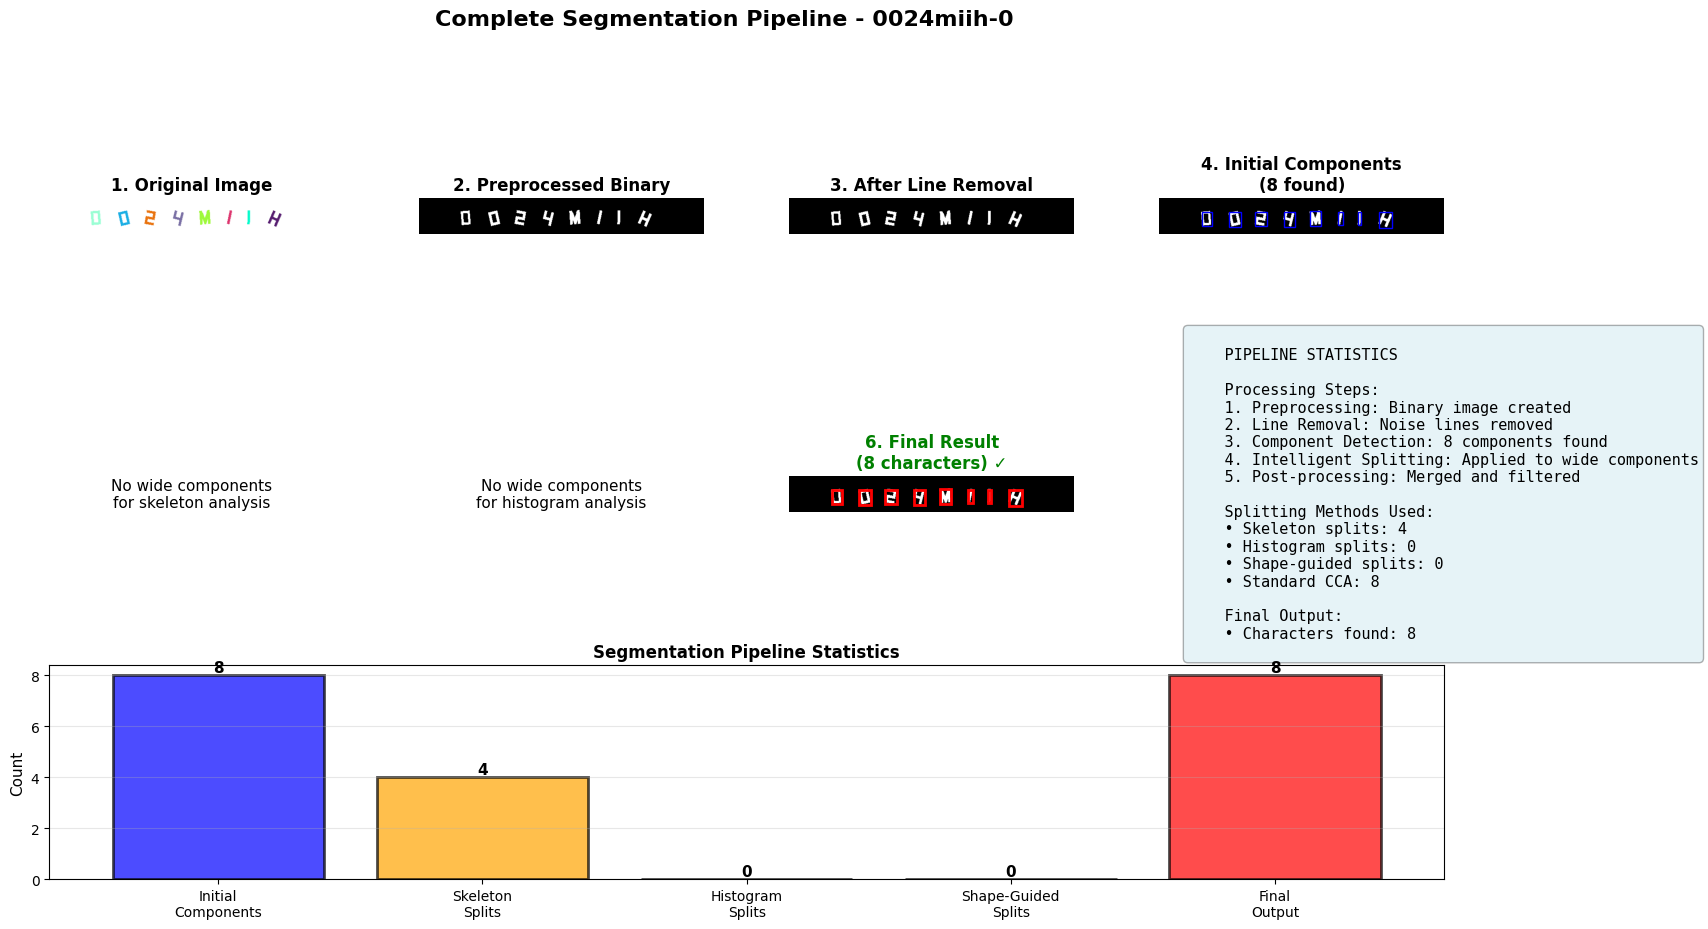



Example 2: 002e23-0


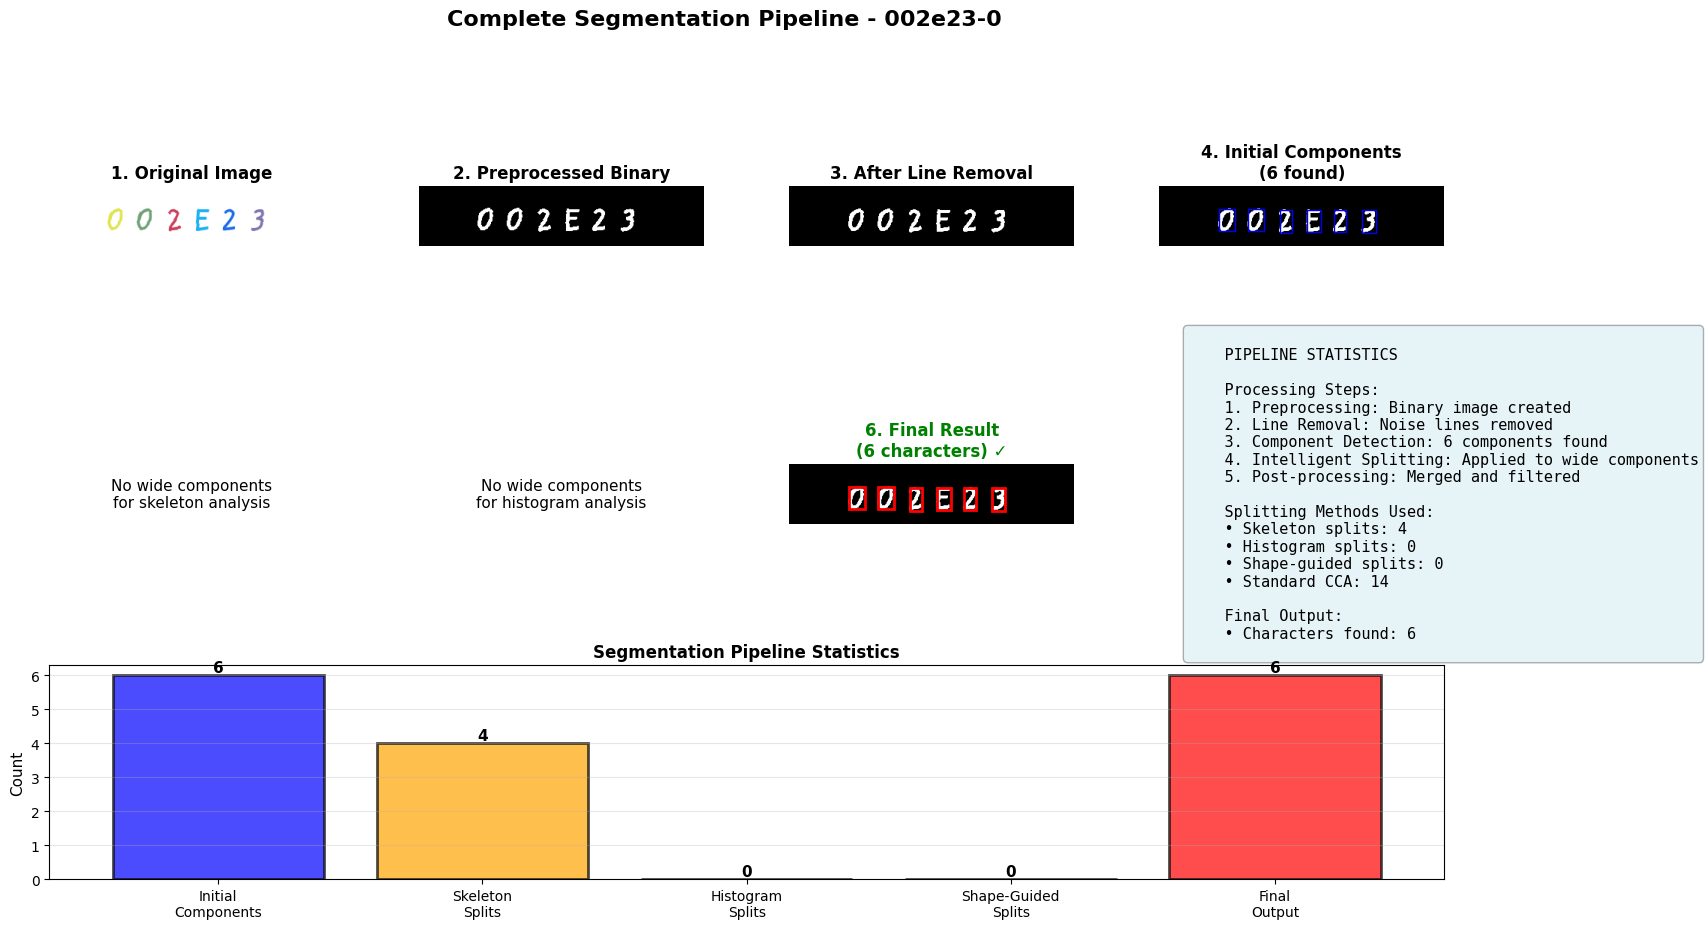



Example 3: 002k-0


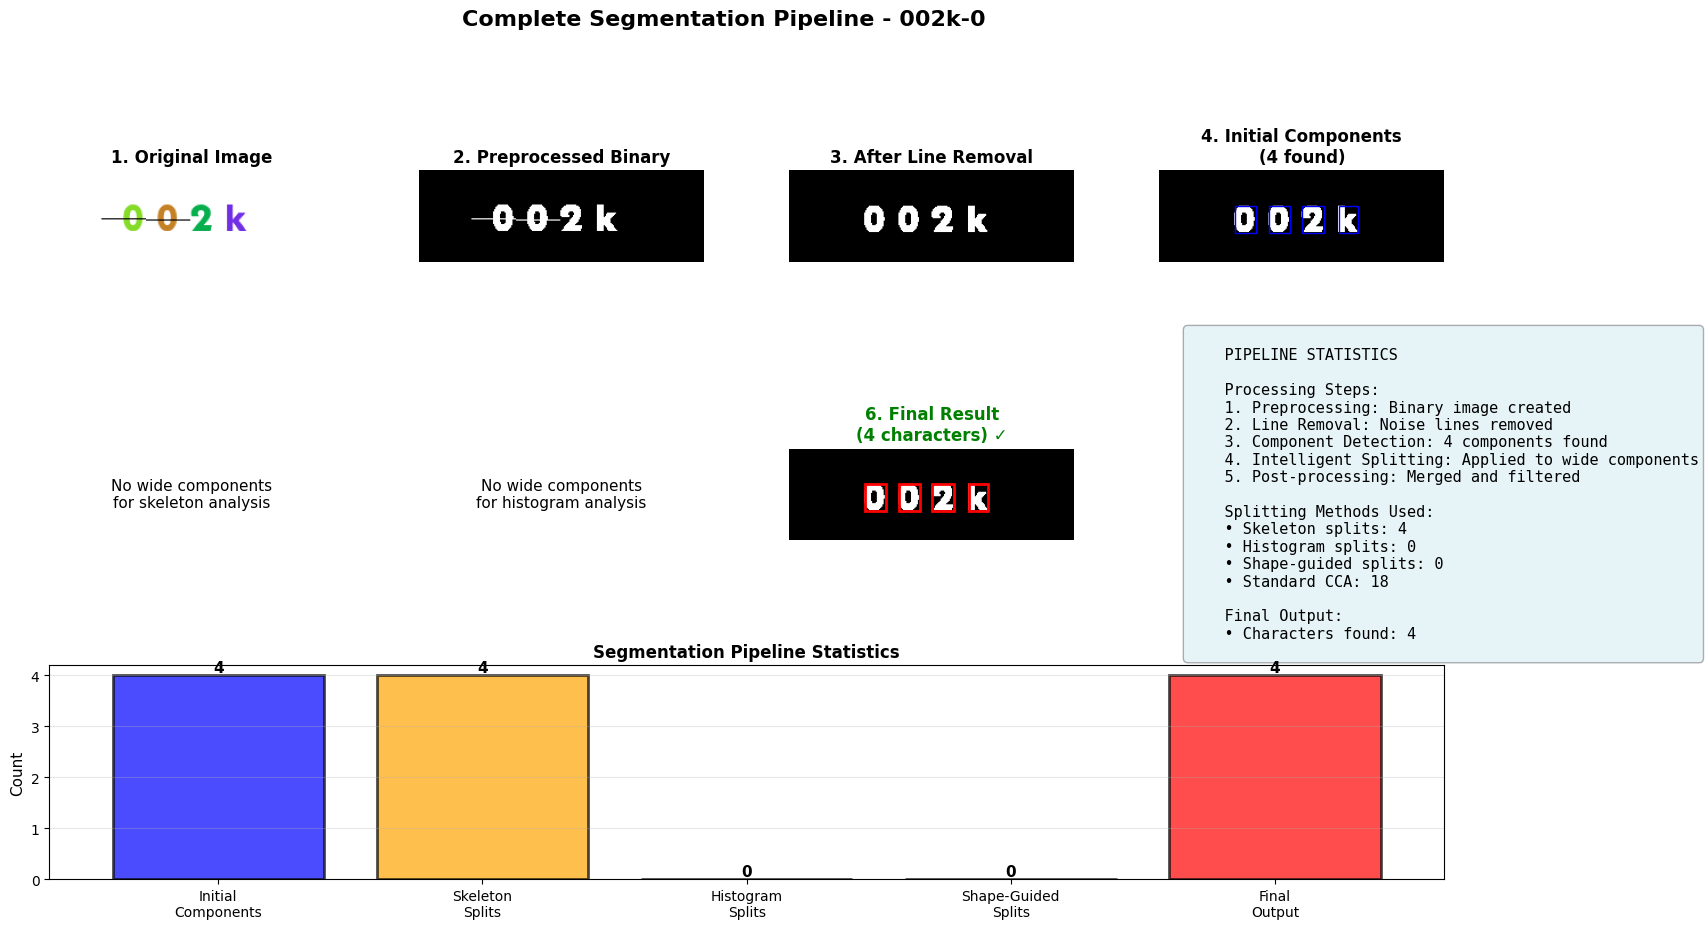

In [32]:
# Visualize Complete Segmentation Pipeline
def visualize_complete_pipeline(image, preprocessor, segmenter, label=""):
    """Show the complete segmentation pipeline step-by-step"""
    
    # Step 1: Preprocess
    binary = preprocessor.preprocess(image)
    
    # Step 2: Clean image
    cleaned = segmenter._clean_image(binary)
    
    # Step 3: Find initial components
    components = segmenter._find_components(cleaned, min_width=5, min_height=10)
    
    # Step 4: Intelligent splitting
    avg_width = np.median([c[2] - c[0] for c in components]) if components else 30
    expected_chars = len(components)  # Approximate
    
    final_boxes = segmenter.segment(binary, expected_chars=expected_chars, 
                                    min_char_width=5, min_char_height=10)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: Input and preprocessing
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('1. Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('2. Preprocessed Binary', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(cleaned, cmap='gray')
    ax3.set_title('3. After Line Removal', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Show initial components
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(cleaned, cmap='gray')
    ax4.set_title(f'4. Initial Components\n({len(components)} found)', 
                  fontsize=12, fontweight='bold')
    for x1, y1, x2, y2 in components:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=1, edgecolor='blue', facecolor='none')
        ax4.add_patch(rect)
    ax4.axis('off')
    
    # Row 2: Splitting methods
    # Show skeleton detection
    wide_box = None
    for box in components:
        if (box[2] - box[0]) > avg_width * 1.3:
            wide_box = box
            break
    
    if wide_box:
        skeleton_boxes = segmenter._split_by_skeleton(cleaned, wide_box)
        ax5 = fig.add_subplot(gs[1, 0])
        ax5.imshow(cleaned, cmap='gray')
        ax5.set_title(f'5a. Skeleton Split\n({len(skeleton_boxes)} result{"s" if len(skeleton_boxes) != 1 else ""})', 
                     fontsize=11)
        for x1, y1, x2, y2 in skeleton_boxes:
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor='red', facecolor='none')
            ax5.add_patch(rect)
        ax5.axis('off')
    else:
        ax5 = fig.add_subplot(gs[1, 0])
        ax5.text(0.5, 0.5, 'No wide components\nfor skeleton analysis', 
                ha='center', va='center', fontsize=11)
        ax5.axis('off')
    
    # Show histogram analysis
    if wide_box:
        histogram_boxes = segmenter._split_by_histogram(cleaned, wide_box, avg_width)
        ax6 = fig.add_subplot(gs[1, 1])
        ax6.imshow(cleaned, cmap='gray')
        ax6.set_title(f'5b. Histogram Split\n({len(histogram_boxes)} result{"s" if len(histogram_boxes) != 1 else ""})', 
                     fontsize=11)
        for x1, y1, x2, y2 in histogram_boxes:
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor='red', facecolor='none')
            ax6.add_patch(rect)
        ax6.axis('off')
    else:
        ax6 = fig.add_subplot(gs[1, 1])
        ax6.text(0.5, 0.5, 'No wide components\nfor histogram analysis', 
                ha='center', va='center', fontsize=11)
        ax6.axis('off')
    
    # Final result
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.imshow(cleaned, cmap='gray')
    ax7.set_title(f'6. Final Result\n({len(final_boxes)} characters) ✓', 
                  fontsize=12, fontweight='bold', color='green')
    for x1, y1, x2, y2 in final_boxes:
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor='red', facecolor='none')
        ax7.add_patch(rect)
    ax7.axis('off')
    
    # Statistics
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.axis('off')
    stats_text = f"""
    PIPELINE STATISTICS
    
    Processing Steps:
    1. Preprocessing: Binary image created
    2. Line Removal: Noise lines removed
    3. Component Detection: {len(components)} components found
    4. Intelligent Splitting: Applied to wide components
    5. Post-processing: Merged and filtered
    
    Splitting Methods Used:
    • Skeleton splits: {segmenter.stats['skeleton_splits']}
    • Histogram splits: {segmenter.stats['histogram_splits']}
    • Shape-guided splits: {segmenter.stats['shape_guided_splits']}
    • Standard CCA: {segmenter.stats['standard_cca']}
    
    Final Output:
    • Characters found: {len(final_boxes)}
    """
    ax8.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # Row 3: Comparison chart
    ax9 = fig.add_subplot(gs[2, :])
    methods = ['Initial\nComponents', 'Skeleton\nSplits', 'Histogram\nSplits', 
               'Shape-Guided\nSplits', 'Final\nOutput']
    counts = [
        len(components),
        segmenter.stats['skeleton_splits'],
        segmenter.stats['histogram_splits'],
        segmenter.stats['shape_guided_splits'],
        len(final_boxes)
    ]
    colors = ['blue', 'orange', 'green', 'purple', 'red']
    bars = ax9.bar(methods, counts, color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=2)
    ax9.set_ylabel('Count', fontsize=11)
    ax9.set_title('Segmentation Pipeline Statistics', fontsize=12, fontweight='bold')
    ax9.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, counts):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    if label:
        plt.suptitle(f'Complete Segmentation Pipeline - {label}', 
                     fontsize=16, fontweight='bold', y=0.98)
    else:
        plt.suptitle('Complete Segmentation Pipeline', 
                     fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'components': components,
        'final_boxes': final_boxes,
        'stats': segmenter.stats.copy()
    }

# Test complete pipeline on multiple examples
print("="*70)
print("COMPLETE SEGMENTATION PIPELINE: END-TO-END")
print("="*70)
print()

for i, (img, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f"\n{'='*70}")
    print(f"Example {i+1}: {label}")
    print('='*70)
    result = visualize_complete_pipeline(img, preprocessor, segmenter, label=label)
    print()


## Summary: Segmentation Techniques and Their Impact

### Technique Comparison Table

| Technique | Problem Solved | Method | Improvement |
|-----------|---------------|--------|-------------|
| **Skeleton Junction Detection** | Characters merge at junction points | Skeletonize and detect 3+ neighbor pixels | Precise splitting at character junctions |
| **Histogram Projection** | Conglutinated characters without clear junctions | Analyze vertical projection peaks/valleys | Handles merged characters using pixel distribution |
| **Shape-Guided Analysis** | Complex merged characters missed by other methods | Topological features (Euler, endpoints, convex hull) | Catches complex cases with shape complexity |
| **Intelligent Pipeline** | Different merging scenarios need different methods | Multi-stage pipeline trying methods in order | Combines strengths of all techniques |

### Key Insights

1. **Skeleton-based approach** excels for characters with clear junction points
2. **Histogram analysis** handles conglutinated characters using statistical patterns
3. **Shape features** provide complementary signals for complex cases
4. **Intelligent pipeline** ensures robust performance by trying multiple methods
5. **Combined approach** significantly improves segmentation accuracy for touching/merged characters
